In [1]:
from github import Github, ContentFile
from github.Repository import Repository
import zipfile
from IPython.display import display, HTML

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import os

from typing import List

In [2]:
import logging
logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger('urllib3').setLevel(logging.INFO)
logging.getLogger('github').setLevel(logging.INFO)
log = logging.getLogger(__name__)

In [3]:
GITHUB_TOKEN = os.getenv('GITHUB_PUBLIC_READ_TOKEN')
assert GITHUB_TOKEN is not None

In [4]:
CSV_PATH = 'CSV'
GITHUB_REPO = 'CSSEGISandData/COVID-19'

def get_csvs():
    g = Github(login_or_token=GITHUB_TOKEN)
    repo = g.get_repo(GITHUB_REPO)
    c = repo.get_contents('csse_covid_19_data/csse_covid_19_daily_reports')

    local_csvs = glob.glob(os.path.join(CSV_PATH, '*.csv'))
    local_csvs = list(map(os.path.basename, local_csvs))
    need_dowload = [f for f in c if f.path.endswith('.csv') and os.path.basename(f.path) not in local_csvs]
    for cf in need_dowload:
        fn = os.path.basename(cf.path)
        log.info(f'writing {fn}')
        with open(os.path.join(CSV_PATH, fn), 'wb') as f:
            f.write(cf.decoded_content)

In [5]:
get_csvs()

In [6]:
def path_to_date(path):
    path = os.path.basename(path)
    path = os.path.splitext(path)[0]
    date = pd.Timestamp(f'{path[-4:]}-{path[:2]}-{path[3:5]}')
    return date

def df_from_csv(path):
    column_info = {
        'FIPS': '',
        'Admin2': '',
        'Province_State': 'Province/State',
        'Country_Region': 'Country/Region',
        'Last_Update': 'Last Update',
        'Lat': 'Latitude',
        'Long_': 'Longitude',
        'Confirmed': 'Confirmed',
        'Deaths': 'Deaths',
        'Recovered': 'Recovered',
        'Active': '',
        'Combined_Key': '',
    }

    def combined_key(row):
        keys = ['Admin2', 'Province_State', 'Country_Region']
        values = [row[key] for key in keys]
        r = ', '.join((v for v in values if v and pd.notna(v)))
        return r

    log.debug(f'reading {path}')
    df = pd.read_csv(path)
    df['Date'] = path_to_date(path)
    column_names = list(df.columns)
    for column_name, old_column_name in column_info.items():
        if column_name in column_names:
            continue
        if old_column_name:
            if old_column_name in column_names:
                log.debug(f'{path}: renaming {old_column_name} to {column_name}')
                df.rename(columns={old_column_name: column_name}, inplace=True)
                continue
            else:
                log.debug(f'{path}: adding missing column {column_name}')
                df[column_name] = np.nan
                continue
        if column_name in ['FIPS', 'Admin2']:
            log.debug(f'{path}: adding missing column {column_name}')
            df[column_name] = np.nan
        elif column_name == 'Active':
            log.debug(f'{path}: adding missing column {column_name}')
            df['Active'] = df['Confirmed'] - df['Deaths'] - df['Recovered']
        elif column_name == 'Combined_Key':
            log.debug(f'{path}: adding missing column {column_name}')
            df['Combined_Key'] = df.apply(combined_key, axis=1)
        else:
            raise NotImplementedError(f'Unexpected column name: {column_name}')

    return df

In [7]:
csv_files = glob.glob(os.path.join(CSV_PATH, '*.csv'))
csv_files.sort(reverse=True)
covid = pd.concat(df_from_csv(csv_file) for csv_file in csv_files)

In [8]:
print(covid.columns)
covid.head(2)

Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key', 'Date'],
      dtype='object')


,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Date
0,45001.0,Abbeville,South Carolina,US,2020-04-25 06:30:53,34.223334,-82.461707,24.0,0.0,0.0,24.0,"Abbeville, South Carolina, US",2020-04-24
1,22001.0,Acadia,Louisiana,US,2020-04-25 06:30:53,30.295065,-92.414197,129.0,7.0,0.0,122.0,"Acadia, Louisiana, US",2020-04-24


Looks like 'China' and 'Mainland China' are (almost) equivalent. But the dates overlap

In [9]:
china = covid[covid.Country_Region=='China']
mainland_china = covid[covid.Country_Region=='Mainland China']
print(china.Province_State.unique())
print(mainland_china.Province_State.unique())
print(china.Date.describe())
print(mainland_china.Date.describe())

['Anhui' 'Beijing' 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi'
 'Guizhou' 'Hainan' 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei'
 'Hunan' 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau'
 'Ningxia' 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan'
 'Tianjin' 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang']
['Gansu' 'Hebei' 'Hubei' 'Guangdong' 'Henan' 'Zhejiang' 'Hunan' 'Anhui'
 'Jiangxi' 'Shandong' 'Jiangsu' 'Chongqing' 'Sichuan' 'Heilongjiang'
 'Beijing' 'Shanghai' 'Fujian' 'Guangxi' 'Shaanxi' 'Yunnan' 'Hainan'
 'Guizhou' 'Tianjin' 'Shanxi' 'Liaoning' 'Jilin' 'Xinjiang'
 'Inner Mongolia' 'Ningxia' 'Qinghai' 'Tibet']
count                    1485
unique                     45
top       2020-03-16 00:00:00
freq                       33
first     2020-03-11 00:00:00
last      2020-04-24 00:00:00
Name: Date, dtype: object
count                    1517
unique                     51
top       2020-01-31 00:00:00
freq                       31
first     2020-01-22

Take a look at the 'Mainland China' records which overlap with the 'China' records

In [10]:
first_china = china.Date.min()
print(f"'China' records start at {first_china}")
overlapping_mainland = mainland_china[mainland_china.Date>=first_china]
print(overlapping_mainland)

'China' records start at 2020-03-11 00:00:00
     FIPS Admin2 Province_State  Country_Region          Last_Update      Lat  \
211   NaN    NaN          Gansu  Mainland China  2020-03-11T02:18:28  36.0611   
212   NaN    NaN          Hebei  Mainland China  2020-03-11T02:18:29  38.0428   
206   NaN    NaN          Gansu  Mainland China  2020-03-11T02:18:28  36.0611   
207   NaN    NaN          Hebei  Mainland China  2020-03-11T02:18:29  38.0428   

        Long_  Confirmed  Deaths  Recovered  Active           Combined_Key  \
211  103.8343        0.0     0.0        0.0     0.0  Gansu, Mainland China   
212  114.5149        0.0     0.0        0.0     0.0  Hebei, Mainland China   
206  103.8343        0.0     0.0        0.0     0.0  Gansu, Mainland China   
207  114.5149        0.0     0.0        0.0     0.0  Hebei, Mainland China   

          Date  
211 2020-03-12  
212 2020-03-12  
206 2020-03-11  
207 2020-03-11  


Looks like the 'Mainland China' records which overlap with the 'China' records don't have numbers for Confirmed, Deaths, Recovered, or Active. We might as well get rid of them and then rename 'Mainland China' to 'China'

In [11]:
covid.drop(covid[(covid.Country_Region=='Mainland China') & (covid.Date>=first_china)].index, inplace=True)
covid.loc[covid.Country_Region=='Mainland China', 'Country_Region'] = 'China'

Also 'South Korea" and 'Korea, South' seem to be redundant. But there is no overlap

In [12]:
s_korea = covid[covid.Country_Region == 'South Korea']
ro_korea = covid[covid.Country_Region == 'Republic of Korea']
korea_s = covid[covid.Country_Region == 'Korea, South']
print('s_korea:')
print(s_korea.Date.describe())
print('ro_korea:')
print(ro_korea.Date.describe())
print('korea_s:')
print(korea_s.Date.describe())


s_korea:
count                      48
unique                     48
top       2020-02-17 00:00:00
freq                        1
first     2020-01-22 00:00:00
last      2020-03-09 00:00:00
Name: Date, dtype: object
ro_korea:
count                       1
unique                      1
top       2020-03-10 00:00:00
freq                        1
first     2020-03-10 00:00:00
last      2020-03-10 00:00:00
Name: Date, dtype: object
korea_s:
count                      45
unique                     45
top       2020-03-13 00:00:00
freq                        1
first     2020-03-11 00:00:00
last      2020-04-24 00:00:00
Name: Date, dtype: object


Replace 'South Korea' and 'Republic of Korea' with 'Korea, South'

In [13]:
covid.loc[covid.Country_Region.isin(['South Korea', 'Republic of Korea']), 'Country_Region'] = 'Korea, South'

Finally 'Iran' and 'Iran (Islamic Republic of)' seem to be redundant

In [14]:
iran = covid[covid.Country_Region == 'Iran']
iran_r= covid[covid.Country_Region == 'Iran (Islamic Republic of)']
print(iran.Date.describe())
print(iran_r.Date.describe())

count                      65
unique                     65
top       2020-03-13 00:00:00
freq                        1
first     2020-02-19 00:00:00
last      2020-04-24 00:00:00
Name: Date, dtype: object
count                       1
unique                      1
top       2020-03-10 00:00:00
freq                        1
first     2020-03-10 00:00:00
last      2020-03-10 00:00:00
Name: Date, dtype: object


In [15]:
covid.loc[covid.Country_Region == 'Iran (Islamic Republic of)', 'Country_Region'] = 'Iran'

In [16]:
# set defaults for Deaths, Recovered, and Confirmed
for c in ['Deaths', 'Recovered', 'Confirmed']:
    covid[c].fillna(value=0, inplace=True)

covid.Active.fillna(covid.Confirmed - covid.Deaths - covid.Recovered, inplace = True)

In [17]:
active_wrong = covid[covid.Active != (covid.Confirmed-covid.Deaths-covid.Recovered)]
active_wrong

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Date
1811,12091.0,Okaloosa,Florida,US,2020-04-13 23:07:54,30.691430,-86.592671,103.0,1.0,0.0,102102.0,"Okaloosa, Florida, US",2020-04-13
0,45001.0,Abbeville,South Carolina,US,2020-04-11 22:45:33,34.223334,-82.461707,9.0,0.0,0.0,0.0,"Abbeville, South Carolina, US",2020-04-11
1,22001.0,Acadia,Louisiana,US,2020-04-11 22:45:33,30.295065,-92.414197,98.0,4.0,0.0,0.0,"Acadia, Louisiana, US",2020-04-11
2,51001.0,Accomack,Virginia,US,2020-04-11 22:45:33,37.767072,-75.632346,15.0,0.0,0.0,0.0,"Accomack, Virginia, US",2020-04-11
3,16001.0,Ada,Idaho,US,2020-04-11 22:45:33,43.452658,-116.241552,513.0,6.0,0.0,0.0,"Ada, Idaho, US",2020-04-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3186,NaN,NaN,Prince Edward Island,Canada,3/22/20 23:48,46.510700,-63.416800,3.0,0.0,0.0,0.0,"Prince Edward Island, Canada",2020-03-22
3187,NaN,NaN,Northwest Territories,Canada,3/22/20 23:48,NaN,NaN,1.0,0.0,0.0,0.0,"Northwest Territories, Canada",2020-03-22
3188,NaN,NaN,Diamond Princess,Canada,3/22/20 23:48,0.000000,0.000000,0.0,1.0,0.0,0.0,"Diamond Princess, Canada",2020-03-22
3415,11001.0,District of Columbia,District of Columbia,US,3/22/20 23:45,38.904178,-77.016560,102.0,2.0,0.0,0.0,"District of Columbia,District of Columbia,US",2020-03-22


In [18]:
covid.Active = covid.Confirmed-covid.Deaths-covid.Recovered

We only want to work on sums per country and date and the dataframe will be indexed by country and date


In [19]:
covid = covid.drop(columns=['FIPS', 'Lat', 'Long_']).groupby(by=['Country_Region', 'Date']).sum()

In [20]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9868 entries, (' Azerbaijan', Timestamp('2020-02-28 00:00:00')) to ('occupied Palestinian territory', Timestamp('2020-03-17 00:00:00'))
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Confirmed  9868 non-null   float64
 1   Deaths     9868 non-null   float64
 2   Recovered  9868 non-null   float64
 3   Active     9868 non-null   float64
dtypes: float64(4)
memory usage: 339.9+ KB


In [21]:
covid.head()

Confirmed  Deaths  Recovered  Active
Country_Region Date                                            
 Azerbaijan    2020-02-28        1.0     0.0        0.0     1.0
Afghanistan    2020-02-24        1.0     0.0        0.0     1.0
               2020-02-25        1.0     0.0        0.0     1.0
               2020-02-26        1.0     0.0        0.0     1.0
               2020-02-27        1.0     0.0        0.0     1.0

Get top n impacted countries

In [22]:
N_TOP_IMPACTED = 50
top_impacted = covid.groupby(level=0).max().Confirmed.nlargest(n=N_TOP_IMPACTED).index
top_impacted

Index(['US', 'Spain', 'Italy', 'France', 'Germany', 'United Kingdom', 'Turkey',
       'Iran', 'China', 'Russia', 'Brazil', 'Belgium', 'Canada', 'Netherlands',
       'Switzerland', 'India', 'Portugal', 'Ecuador', 'Peru', 'Ireland',
       'Sweden', 'Saudi Arabia', 'Austria', 'Israel', 'Mexico', 'Japan',
       'Chile', 'Singapore', 'Pakistan', 'Poland', 'Korea, South', 'Romania',
       'United Arab Emirates', 'Belarus', 'Qatar', 'Denmark', 'Indonesia',
       'Ukraine', 'Norway', 'Czechia', 'Philippines', 'Australia', 'Serbia',
       'Dominican Republic', 'Malaysia', 'Panama', 'Colombia', 'Bangladesh',
       'Finland', 'South Africa'],
      dtype='object', name='Country_Region')

Get population data. Data from https://data.worldbank.org/indicator/sp.pop.totl

In [23]:
def read_population_un():
    """
    read population data obtained from https://population.un.org/wpp/Download/Standard/CSV/
    :return:
    """
    df = pd.read_csv('WPP2019_TotalPopulationBySex.csv', header=0)
    df = df[df.Time==2019]
    df = df.set_index('Location')
    df['population'] = df.PopTotal * 1000
    return df

population = read_population_un()
population.info()


<class 'pandas.core.frame.DataFrame'>
Index: 477 entries, Afghanistan to Zimbabwe
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LocID       477 non-null    int64  
 1   VarID       477 non-null    int64  
 2   Variant     477 non-null    object 
 3   Time        477 non-null    int64  
 4   MidPeriod   477 non-null    float64
 5   PopMale     443 non-null    float64
 6   PopFemale   443 non-null    float64
 7   PopTotal    477 non-null    float64
 8   PopDensity  477 non-null    float64
 9   population  477 non-null    float64
dtypes: float64(6), int64(3), object(1)
memory usage: 41.0+ KB


In [24]:
population.loc['Germany']

LocID                276
VarID                  2
Variant           Medium
Time                2019
MidPeriod         2019.5
PopMale          41249.1
PopFemale        42267.9
PopTotal           83517
PopDensity       239.606
population    8.3517e+07
Name: Germany, dtype: object

We want to relate the numbers of the top impacted countries to their population.

Do we have population data for all top impacted countries?

In [25]:
missing_countries = [c for c in top_impacted if c not in population.index]
missing_countries

['US', 'Iran', 'Russia', 'Korea, South']

In [26]:
print('\n'.join(c for c in population.index if 'United States' in c))
print()
print('\n'.join(c for c in population.index if 'Iran' in c))
print()
print('\n'.join(c for c in population.index if 'Russia' in c))
print()
print('\n'.join(c for c in population.index if 'Korea' in c))

United States Virgin Islands
United States of America
United States of America (and dependencies)

Iran (Islamic Republic of)

Russian Federation

Dem. People's Republic of Korea
Republic of Korea


Looks like we can use
* 'United States of America' for 'US'
* 'Iran (Islamic Republic of)' for 'Iran'
* 'Russian Federation' for 'Russia'
* 'Republic of Korea' for 'Korea, South'

For simplicity reasons we simply change the values in the population dataset

In [27]:
mapper = {
    'United States of America': 'US',
    'Iran (Islamic Republic of)': 'Iran',
    'Russian Federation': 'Russia',
    'Republic of Korea': 'Korea, South'}
population.rename(mapper=mapper, inplace=True)
missing_countries = [c for c in top_impacted if c not in population.index]
assert not missing_countries, f'missing: {missing_countries}'

Continue to work only with these top impacted countries.

In [28]:
covid = covid.loc[top_impacted]

Add values relative to population size

In [29]:
for c in ['Confirmed', 'Deaths', 'Recovered', 'Active']:
    covid[f'{c}_per_100k'] = covid[c] / population.loc[covid.index.get_level_values('Country_Region')].PopTotal.values * 100

In [30]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3380 entries, ('Australia', Timestamp('2020-01-23 00:00:00')) to ('United Kingdom', Timestamp('2020-04-24 00:00:00'))
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Confirmed           3380 non-null   float64
 1   Deaths              3380 non-null   float64
 2   Recovered           3380 non-null   float64
 3   Active              3380 non-null   float64
 4   Confirmed_per_100k  3380 non-null   float64
 5   Deaths_per_100k     3380 non-null   float64
 6   Recovered_per_100k  3380 non-null   float64
 7   Active_per_100k     3380 non-null   float64
dtypes: float64(8)
memory usage: 223.8+ KB


In [31]:
covid.head()

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Australia      2020-01-23        0.0     0.0        0.0     0.0   
               2020-01-25        4.0     0.0        0.0     4.0   
               2020-01-26        4.0     0.0        0.0     4.0   
               2020-01-27        5.0     0.0        0.0     5.0   
               2020-01-28        5.0     0.0        0.0     5.0   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Australia      2020-01-23            0.000000              0.0   
               2020-01-25            0.015871              0.0   
               2020-01-26            0.015871              0.0   
               2020-01-27            0.019839              0.0   
               2020-01-28            0.019839              0.0   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Australia      2020-01-23                 0.0         0.000000  
               2020-01-25                 0.0         0.015871  
               2020-01-26                 0.0         0.015871  
               2020-01-27                 0.0         0.019839  
               2020-01-28                 0.0         0.019839

In [32]:
covid_max = covid.groupby(level='Country_Region').max()
covid_max['population'] = population.loc[covid_max.index].PopTotal * 1000
covid_max['recovered_per_confirmed'] = covid_max.Recovered / covid_max.Confirmed
covid_max['deaths_per_confirmed'] = covid_max.Deaths / covid_max.Confirmed
covid_max.info()
covid_max

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Australia to United Kingdom
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Confirmed                50 non-null     float64
 1   Deaths                   50 non-null     float64
 2   Recovered                50 non-null     float64
 3   Active                   50 non-null     float64
 4   Confirmed_per_100k       50 non-null     float64
 5   Deaths_per_100k          50 non-null     float64
 6   Recovered_per_100k       50 non-null     float64
 7   Active_per_100k          50 non-null     float64
 8   population               50 non-null     float64
 9   recovered_per_confirmed  50 non-null     float64
 10  deaths_per_confirmed     50 non-null     float64
dtypes: float64(11)
memory usage: 4.7+ KB


,Confirmed,Deaths,Recovered,Active,Confirmed_per_100k,Deaths_per_100k,Recovered_per_100k,Active_per_100k,population,recovered_per_confirmed,deaths_per_confirmed
Country_Region,,,,,,,,,,,
Australia,6677.0,79.0,4124.0,4895.0,26.492668,0.313452,16.363002,19.422137,2.520320e+07,0.617643,0.011832
Austria,15071.0,530.0,11872.0,9334.0,168.295011,5.918410,132.572382,104.231015,8.955108e+06,0.787738,0.035167
Bangladesh,4689.0,131.0,112.0,4446.0,2.875872,0.080345,0.068692,2.726835,1.630462e+08,0.023886,0.027938
Belarus,8773.0,63.0,1120.0,7590.0,92.812319,0.666497,11.848831,80.296991,9.452409e+06,0.127664,0.007181
Belgium,44293.0,6679.0,10122.0,27492.0,383.843909,57.880330,87.717428,238.246151,1.153933e+07,0.228524,0.150791
Brazil,54043.0,3704.0,27655.0,22684.0,25.606787,1.755038,13.103560,10.748188,2.110495e+08,0.511722,0.068538
Canada,44056.0,2386.0,15149.0,26521.0,117.762036,6.377797,40.493397,70.890842,3.741104e+07,0.343858,0.054158
Chile,12306.0,174.0,6327.0,5840.0,64.932341,0.918107,33.384278,30.814633,1.895204e+07,0.514139,0.014139
China,83899.0,4636.0,78401.0,58046.0,5.851580,0.323340,5.468119,4.048449,1.433784e+09,0.934469,0.055257


In [33]:
covid_max.sort_values(by='Confirmed',ascending=False).loc[:,['Confirmed', 'Deaths']]

,Confirmed,Deaths
Country_Region,,
US,905168.0,51940.0
Spain,219764.0,22524.0
Italy,192994.0,25969.0
France,159952.0,22279.0
Germany,154999.0,5760.0
United Kingdom,144640.0,19567.0
Turkey,104912.0,2600.0
Iran,88194.0,5574.0
China,83899.0,4636.0


In [34]:
covid_max.sort_values(by='Confirmed_per_100k',ascending=False).loc[:,['Confirmed_per_100k', 'Confirmed', 'Deaths']]

,Confirmed_per_100k,Confirmed,Deaths
Country_Region,,,
Spain,470.216370,219764.0,22524.0
Belgium,383.843909,44293.0,6679.0
Ireland,372.432308,18184.0,1014.0
Switzerland,333.788791,28677.0,1589.0
Italy,318.734446,192994.0,25969.0
Qatar,301.016465,8525.0,10.0
US,275.072775,905168.0,51940.0
France,245.589837,159952.0,22279.0
Portugal,222.927862,22797.0,854.0


In [35]:
covid_max.sort_values(by='deaths_per_confirmed',ascending=False).loc[:,['Confirmed', 'Deaths', 'deaths_per_confirmed']]

,Confirmed,Deaths,deaths_per_confirmed
Country_Region,,,
Belgium,44293.0,6679.0,0.150791
France,159952.0,22279.0,0.139286
United Kingdom,144640.0,19567.0,0.135281
Italy,192994.0,25969.0,0.134559
Sweden,17567.0,2152.0,0.122502
Netherlands,36729.0,4304.0,0.117183
Spain,219764.0,22524.0,0.102492
Mexico,12872.0,1221.0,0.094857
Indonesia,8211.0,689.0,0.083912


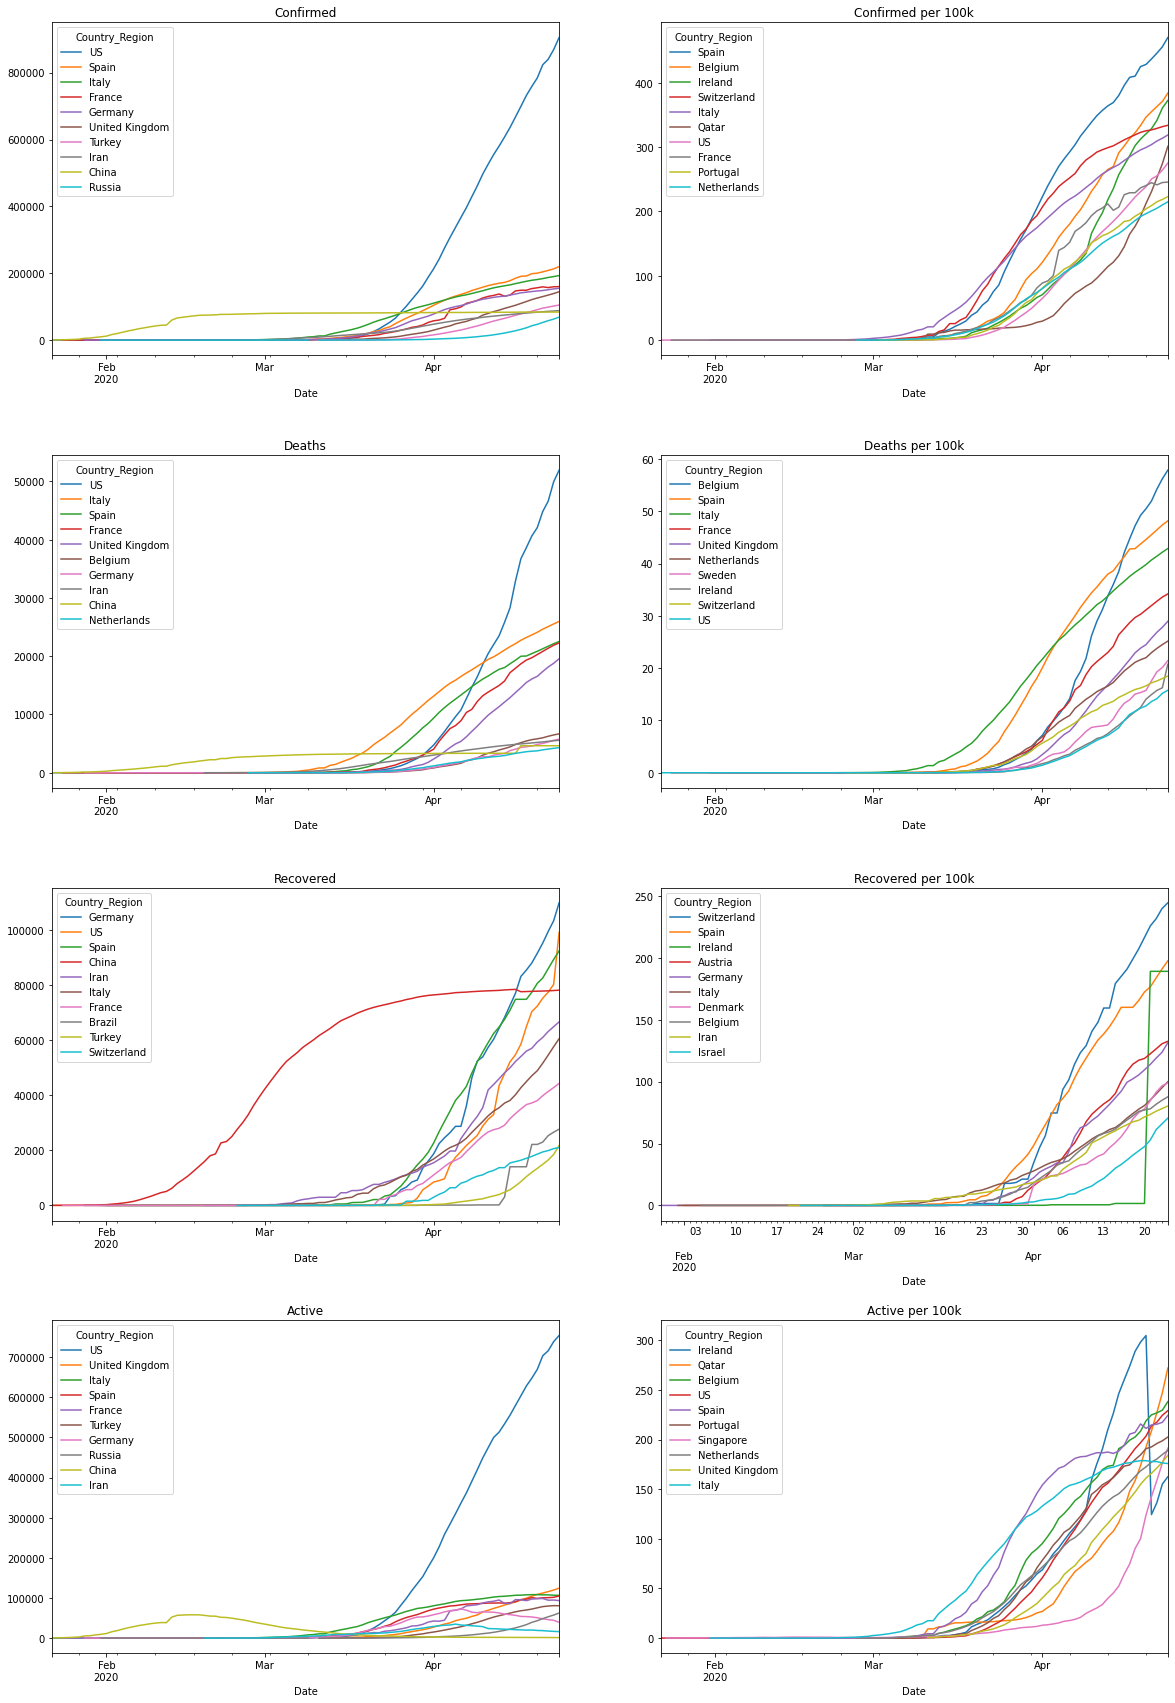

In [36]:
fig, axes = plt.subplots(4, 2, figsize=(20,30))
for i, column in enumerate(covid.columns):
    ax_r = i % 4
    ax_c = int(i/4)
    ax = axes[ax_r, ax_c]
    top_countries = covid_max.nlargest(n=10, columns=column, keep='all').sort_values(by=column, ascending=False).index
    p = covid.loc[top_countries]
    p = p.pivot_table(index=p.index.get_level_values('Date'), 
                      columns=p.index.get_level_values('Country_Region'), 
                      values=column)

    p = p.reindex(columns=top_countries)
    p.plot(title=column.replace('_', ' '), logy=False, ax=ax)

fig.subplots_adjust(hspace=0.3)

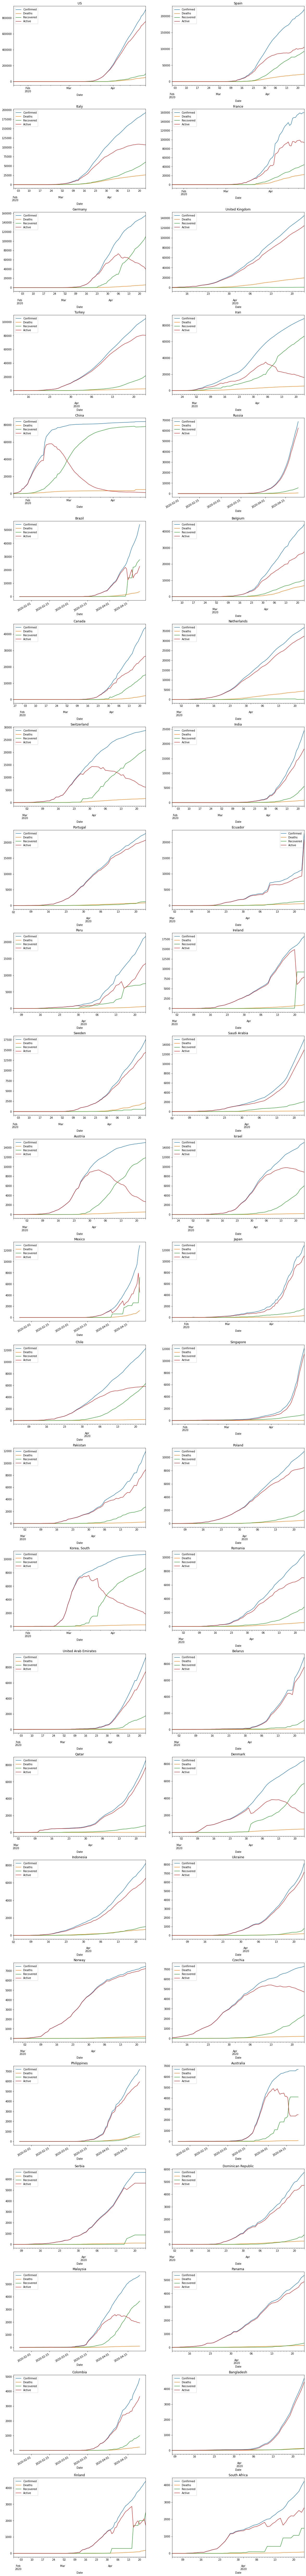

In [37]:
from math import ceil
top_countries = covid_max.nlargest(n=N_TOP_IMPACTED, columns='Confirmed').index
fig, axes = plt.subplots(int(ceil(N_TOP_IMPACTED / 2)), 2, figsize=(20, 4 * N_TOP_IMPACTED))
for i, country in enumerate(top_countries):
    ax_r = int(i / 2)
    ax_c = i % 2
    ax = axes[ax_r, ax_c]
    covid.loc[country].plot(y=['Confirmed', 'Deaths', 'Recovered', 'Active'], 
                            ax = ax, title=country, logy=False)
    

fig.subplots_adjust(hspace=0.3)

We want to add columns with differences. To smooth the differences we calculate the differences on a rolling window (size 5)

In [38]:
d=covid.groupby(level='Country_Region').rolling(window=5).mean().diff()
d

Confirmed  Deaths  Recovered  \
Country_Region Country_Region Date                                       
Australia      Australia      2020-01-23        NaN     NaN        NaN   
                              2020-01-25        NaN     NaN        NaN   
                              2020-01-26        NaN     NaN        NaN   
                              2020-01-27        NaN     NaN        NaN   
                              2020-01-28        NaN     NaN        NaN   
...                                             ...     ...        ...   
United Kingdom United Kingdom 2020-04-20     5274.6   731.2       15.6   
                              2020-04-21     5205.4   723.8       52.6   
                              2020-04-22     4973.8   708.8       57.8   
                              2020-04-23     4786.4   658.6       59.6   
                              2020-04-24     4693.6   694.4       57.6   

                                          Active  Confirmed_per_100k  \
Country_Region Country_Region Date                                     
Australia      Australia      2020-01-23     NaN                 NaN   
                              2020-01-25     NaN                 NaN   
                              2020-01-26     NaN                 NaN   
                              2020-01-27     NaN                 NaN   
                              2020-01-28     NaN                 NaN   
...                                          ...                 ...   
United Kingdom United Kingdom 2020-04-20  4527.8            7.810732   
                              2020-04-21  4429.0            7.708259   
                              2020-04-22  4207.2            7.365302   
                              2020-04-23  4068.2            7.087796   
                              2020-04-24  3941.6            6.950376   

                                          Deaths_per_100k  Recovered_per_100k  \
Country_Region Country_Region Date                                              
Australia      Australia      2020-01-23              NaN                 NaN   
                              2020-01-25              NaN                 NaN   
                              2020-01-26              NaN                 NaN   
                              2020-01-27              NaN                 NaN   
                              2020-01-28              NaN                 NaN   
...                                                   ...                 ...   
United Kingdom United Kingdom 2020-04-20         1.082775            0.023101   
                              2020-04-21         1.071817            0.077891   
                              2020-04-22         1.049605            0.085591   
                              2020-04-23         0.975268            0.088257   
                              2020-04-24         1.028281            0.085295   

                                          Active_per_100k  
Country_Region Country_Region Date                         
Australia      Australia      2020-01-23              NaN  
                              2020-01-25              NaN  
                              2020-01-26              NaN  
                              2020-01-27              NaN  
                              2020-01-28              NaN  
...                                                   ...  
United Kingdom United Kingdom 2020-04-20         6.704856  
                              2020-04-21         6.558551  
                              2020-04-22         6.230105  
                              2020-04-23         6.024271  
                              2020-04-24         5.836799  

[3380 rows x 8 columns]

For some reason the 1st index level is duplicated

In [39]:
d = d.reset_index(level=0, drop=True)
d

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Australia      2020-01-23        NaN     NaN        NaN     NaN   
               2020-01-25        NaN     NaN        NaN     NaN   
               2020-01-26        NaN     NaN        NaN     NaN   
               2020-01-27        NaN     NaN        NaN     NaN   
               2020-01-28        NaN     NaN        NaN     NaN   
...                              ...     ...        ...     ...   
United Kingdom 2020-04-20     5274.6   731.2       15.6  4527.8   
               2020-04-21     5205.4   723.8       52.6  4429.0   
               2020-04-22     4973.8   708.8       57.8  4207.2   
               2020-04-23     4786.4   658.6       59.6  4068.2   
               2020-04-24     4693.6   694.4       57.6  3941.6   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Australia      2020-01-23                 NaN              NaN   
               2020-01-25                 NaN              NaN   
               2020-01-26                 NaN              NaN   
               2020-01-27                 NaN              NaN   
               2020-01-28                 NaN              NaN   
...                                       ...              ...   
United Kingdom 2020-04-20            7.810732         1.082775   
               2020-04-21            7.708259         1.071817   
               2020-04-22            7.365302         1.049605   
               2020-04-23            7.087796         0.975268   
               2020-04-24            6.950376         1.028281   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Australia      2020-01-23                 NaN              NaN  
               2020-01-25                 NaN              NaN  
               2020-01-26                 NaN              NaN  
               2020-01-27                 NaN              NaN  
               2020-01-28                 NaN              NaN  
...                                       ...              ...  
United Kingdom 2020-04-20            0.023101         6.704856  
               2020-04-21            0.077891         6.558551  
               2020-04-22            0.085591         6.230105  
               2020-04-23            0.088257         6.024271  
               2020-04-24            0.085295         5.836799  

[3380 rows x 8 columns]

Verify that the rolling values get reset at the country boundaries

In [40]:
len_of_first_group = d.loc[d.index.get_level_values(0)[0]].shape[0]
len_of_first_group

92

In [41]:
d.iloc[len_of_first_group-5:len_of_first_group+10]

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Australia      2020-04-20       21.4     0.8      387.6  -367.0   
               2020-04-21       17.0     0.8      353.8  -337.6   
               2020-04-22        5.0     0.2       63.2   -58.4   
               2020-04-23       22.8     1.6        0.0    21.2   
               2020-04-24       26.0     2.4        0.0    23.6   
Austria        2020-02-25        NaN     NaN        NaN     NaN   
               2020-02-26        NaN     NaN        NaN     NaN   
               2020-02-27        NaN     NaN        NaN     NaN   
               2020-02-28        NaN     NaN        NaN     NaN   
               2020-02-29        NaN     NaN        NaN     NaN   
               2020-03-01        2.4     0.0        0.0     2.4   
               2020-03-02        3.2     0.0        0.0     3.2   
               2020-03-03        3.6     0.0        0.0     3.6   
               2020-03-04        5.2     0.0        0.0     5.2   
               2020-03-05        6.4     0.0        0.0     6.4   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Australia      2020-04-20            0.084910         0.003174   
               2020-04-21            0.067452         0.003174   
               2020-04-22            0.019839         0.000794   
               2020-04-23            0.090465         0.006348   
               2020-04-24            0.103162         0.009523   
Austria        2020-02-25                 NaN              NaN   
               2020-02-26                 NaN              NaN   
               2020-02-27                 NaN              NaN   
               2020-02-28                 NaN              NaN   
               2020-02-29                 NaN              NaN   
               2020-03-01            0.026800         0.000000   
               2020-03-02            0.035734         0.000000   
               2020-03-03            0.040201         0.000000   
               2020-03-04            0.058067         0.000000   
               2020-03-05            0.071468         0.000000   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Australia      2020-04-20            1.537900        -1.456164  
               2020-04-21            1.403790        -1.339512  
               2020-04-22            0.250762        -0.231717  
               2020-04-23            0.000000         0.084116  
               2020-04-24            0.000000         0.093639  
Austria        2020-02-25                 NaN              NaN  
               2020-02-26                 NaN              NaN  
               2020-02-27                 NaN              NaN  
               2020-02-28                 NaN              NaN  
               2020-02-29                 NaN              NaN  
               2020-03-01            0.000000         0.026800  
               2020-03-02            0.000000         0.035734  
               2020-03-03            0.000000         0.040201  
               2020-03-04            0.000000         0.058067  
               2020-03-05            0.000000         0.071468

In [42]:
covid=covid.join(other=d,rsuffix='_diff')
covid.iloc[80:95]

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Australia      2020-04-13     6351.0    61.0     1806.0  4484.0   
               2020-04-14     6415.0    62.0     2186.0  4167.0   
               2020-04-15     6440.0    63.0     2186.0  4191.0   
               2020-04-16     6462.0    63.0     2355.0  4044.0   
               2020-04-17     6522.0    66.0     3808.0  2648.0   
               2020-04-18     6547.0    67.0     4124.0  2356.0   
               2020-04-19     6547.0    67.0     4124.0  2356.0   
               2020-04-20     6547.0    67.0     4124.0  2356.0   
               2020-04-21     6547.0    67.0     4124.0  2356.0   
               2020-04-22     6547.0    67.0     4124.0  2356.0   
               2020-04-23     6661.0    75.0     4124.0  2462.0   
               2020-04-24     6677.0    79.0     4124.0  2474.0   
Austria        2020-02-25        2.0     0.0        0.0     2.0   
               2020-02-26        2.0     0.0        0.0     2.0   
               2020-02-27        3.0     0.0        0.0     3.0   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Australia      2020-04-13           25.199181         0.242033   
               2020-04-14           25.453117         0.246001   
               2020-04-15           25.552311         0.249968   
               2020-04-16           25.639601         0.249968   
               2020-04-17           25.877666         0.261872   
               2020-04-18           25.976860         0.265839   
               2020-04-19           25.976860         0.265839   
               2020-04-20           25.976860         0.265839   
               2020-04-21           25.976860         0.265839   
               2020-04-22           25.976860         0.265839   
               2020-04-23           26.429184         0.297581   
               2020-04-24           26.492668         0.313452   
Austria        2020-02-25            0.022334         0.000000   
               2020-02-26            0.022334         0.000000   
               2020-02-27            0.033500         0.000000   

                           Recovered_per_100k  Active_per_100k  \
Country_Region Date                                              
Australia      2020-04-13            7.165757        17.791392   
               2020-04-14            8.673502        16.533615   
               2020-04-15            8.673502        16.628841   
               2020-04-16            9.344052        16.045582   
               2020-04-17           15.109192        10.506602   
               2020-04-18           16.363002         9.348019   
               2020-04-19           16.363002         9.348019   
               2020-04-20           16.363002         9.348019   
               2020-04-21           16.363002         9.348019   
               2020-04-22           16.363002         9.348019   
               2020-04-23           16.363002         9.768601   
               2020-04-24           16.363002         9.816214   
Austria        2020-02-25            0.000000         0.022334   
               2020-02-26            0.000000         0.022334   
               2020-02-27            0.000000         0.033500   

                           Confirmed_diff  Deaths_diff  Recovered_diff  \
Country_Region Date                                                      
Australia      2020-04-13            68.2          2.2           145.2   
               2020-04-14            61.4          2.2           142.8   
               2020-04-15            45.0          1.8            78.6   
               2020-04-16            31.8          1.2           109.8   
               2020-04-17            41.4          1.2           400.4   
               2020-04-18            39.2          1.2           463.6   
               2020-04-19            26.4        

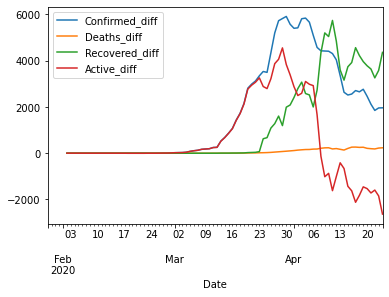

In [43]:
covid.loc[('Germany',),['Confirmed_diff', 'Deaths_diff', 'Recovered_diff', 'Active_diff']].plot()

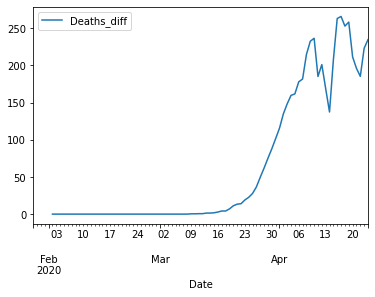

In [44]:
covid.loc[('Germany',),['Deaths_diff']].plot()

In [45]:
display(HTML(covid.loc[('Germany',),['Deaths','Deaths_diff']].to_html()))

,Deaths,Deaths_diff
Date,,
2020-01-28,0.0,NaN
2020-01-29,0.0,NaN
2020-01-30,0.0,NaN
2020-01-31,0.0,NaN
2020-02-01,0.0,NaN
2020-02-02,0.0,0.0
2020-02-03,0.0,0.0
2020-02-04,0.0,0.0
2020-02-05,0.0,0.0


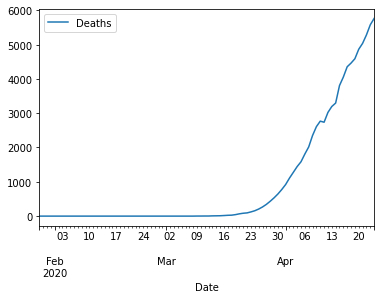

In [46]:
covid.loc[('Germany',),['Deaths']].plot()